In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn import cross_validation
from sklearn.model_selection import KFold
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/maxsimon/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
# create a kfold instance (for the performance measurements)
kf = KFold(n_splits=10)

## Dimension reduction

In [5]:
# Dimension reduction

# pixels representing 3
pixels_3 = [(2,2,1), (3,2,1)]
# pixels representing 9
pixels_9 = [(4,4,1)]

def flat_ind(index):
    return np.ravel_multi_index(index, (8, 8))

def reduce_dim(x):
    reduced = np.empty((x.shape[0], 2))
    # first feature is large for a digit 3
    reduced[:,0] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_3], axis=0)
    # second feature is large for a digit 9
    reduced[:,1] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_9], axis=0)
    return reduced

## Prepare training and testsets

In [6]:
# use only 3 and 9 for this exercise
mask_all = np.logical_or(target == 3, target == 9)
X_all = data[mask_all]
y_all = target[mask_all]

X_train , X_test , y_train , y_test = cross_validation.train_test_split(X_all, y_all, test_size=0.4, random_state=0)

X_all_r = reduce_dim(X_all)
X_train_r , X_test_r , y_train , y_test = cross_validation.train_test_split(X_all_r, y_all, test_size=0.4, random_state=0)


# Implementation of Naive Bayes

In [7]:
def fit_naive_bayes(features, labels, bincount, possible_labels=[3, 9]):

    np_bin_calc = bincount # this is the argument for numpy.histogram for determining the binning
    
    if bincount == 0: # get our own binning
        all_l = np.array([])
        for i, label in enumerate(possible_labels):
            # calculate for each label: iqr, n, d (full range of data) and out of these L
            iqr = np.percentile(features[labels == label], 75, axis=0) - np.percentile(features[labels == label], 25, axis=0)
            n = features[labels == label].shape[0]
            d = (np.max(features[labels == label], axis=0) - np.min(features[labels == label], axis=0))

            mask = iqr != 0
            all_l = np.append(all_l, d[mask]/(2*iqr[mask]/n**(1/3)))

        # set the largest L as the bincount (see below)
        bincount = int(np.ceil(np.max(all_l)))
        # tell numpy later to use the Freedman Diaconis Estimator
        np_bin_calc = 'fd'
    
    # create arrays for later
    histo = np.zeros((len(possible_labels), features.shape[1], bincount))
    # the return variable binning will have the dimensions: CxDx3
    # this is because I decided to use for each histogram the optimal/predicted L, if bincount is not given
    # in order to do so, the last dimension of the histogram must be the largest L in the whole data (see above)
    # on the other hand, histogram overflow can only be handled by knowing, where the histogram stops, therefore I also store the chosen L for each histogram in the binning variable 
    binning = np.zeros((len(possible_labels), features.shape[1], 3)) # the last dimension is 3 not 2 ( see above )
    
    for i, label in enumerate(possible_labels):
        for j in range(features.shape[1]): # loop over feature dimensions
            
            # create the histogram
            np_hist = np.histogram(features[labels == label, j], bins=np_bin_calc, density=True)
            # store histogram
            histo[i, j][:np_hist[0].shape[0]] = np_hist[0]
            # save first edge of histogram
            binning[i, j, 0] = np_hist[1][0]
            # save bin width of histogram
            binning[i, j, 1] = np.abs(np_hist[1][1] - np_hist[1][0])
            # store number of bins (L) of histogram
            binning[i, j, 2] = np_hist[0].shape[0]
    
    return histo, binning
    

In [8]:
def predict_naive_bayes(test_features, histograms, binning, possible_labels=[3, 9]):
    scores = np.empty((len(possible_labels), test_features.shape[0]))
    for k in range(len(possible_labels)):   
        reshaped_binning = np.array([binning[k] for _ in range(test_features.shape[0])])

        hist_ind = np.int_(np.floor((test_features - reshaped_binning[:, :, 0])/reshaped_binning[:, :, 1]))
        # handle underflow
        hist_ind[hist_ind < 0] = 0
        # handle overflow
        hist_ind[hist_ind >= reshaped_binning[:, :, 2]] = reshaped_binning[hist_ind >= reshaped_binning[:, :, 2], 2] - 1
        probs = np.array([histograms[k, j, hist_ind[:, j]] for j in range(test_features.shape[1])])
        
        scores[k] = np.sum(np.log(probs), axis=0)
    
    prediction = np.argmax(scores, axis=0)
    for i, k in enumerate(possible_labels):
        prediction[prediction == i] = k
    
    return prediction
    

In [9]:
def get_confusion_matrix(predicted, truth, possible_labels=[3, 9]):
    conf = np.empty((len(possible_labels), len(possible_labels)))
    for i, k in enumerate(possible_labels):
        items, counts = np.unique(predicted[truth == k], return_counts=True)
        count_array = np.array([counts[np.where(items == tested_k)[0][0]] for tested_k in possible_labels])
        conf[i] = count_array
    return conf

In [10]:
# create a grid for decision regions
grid_feat_1 = np.linspace(np.min(X_all_r[:,0]), np.max(X_all_r[:,0]), 300)
grid_feat_2 = np.linspace(np.min(X_all_r[:,1]), np.max(X_all_r[:,1]), 300)

# thanks to SO, this has suitable dimensions for the algos
grid = np.transpose([np.tile(grid_feat_1, len(grid_feat_2)), np.repeat(grid_feat_2, len(grid_feat_1))])
# this has suitable dimensions for plotting contours
mesh_feat1, mesh_feat2 = np.meshgrid(grid_feat_1, grid_feat_2)

In [11]:
# full feature space
histograms, binning = fit_naive_bayes(X_train, y_train, 8)
test_pred = predict_naive_bayes(X_test, histograms, binning)
conf_ff = get_confusion_matrix(test_pred, y_test)
# Decision region
histograms, binning = fit_naive_bayes(X_train_r, y_train, 0)
grid_pred = predict_naive_bayes(grid, histograms, binning)
# 2D-Feature space
histograms_2f, binning_2f = fit_naive_bayes(X_train_r, y_train, 0)
test_pred_r = predict_naive_bayes(X_test_r, histograms_2f, binning_2f)
conf_2f = get_confusion_matrix(test_pred_r, y_test)

/Users/maxsimon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


## Visualisation


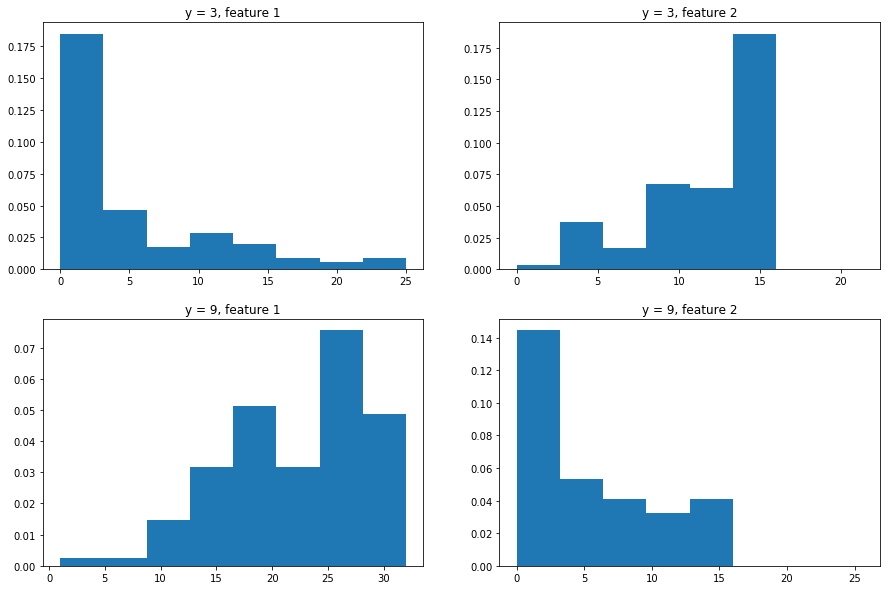

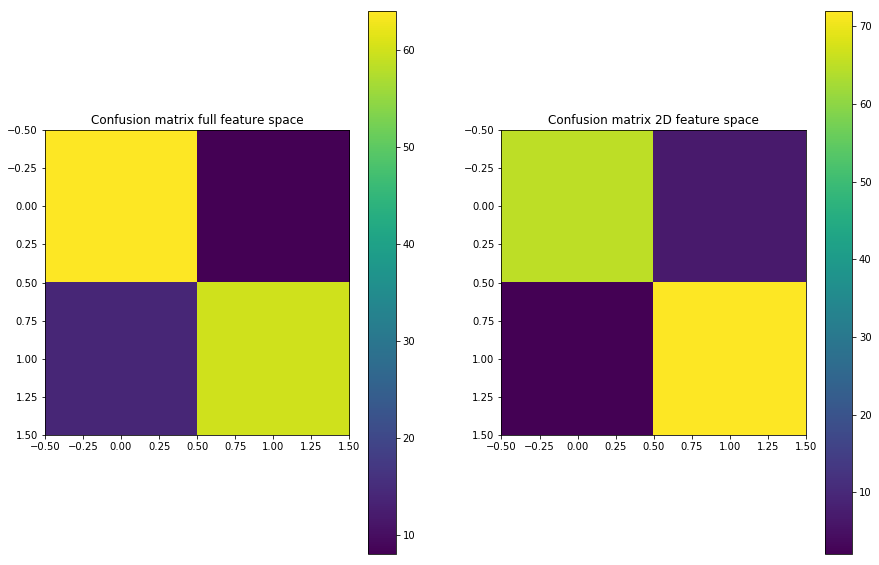

In [14]:
# Histogramms
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].set_title('y = 3, feature 1')
ax[0][0].bar([binning_2f[0][0][0] + (i + 0.5)*binning_2f[0][0][1] for i in range(histograms_2f[0][0].shape[0])], histograms_2f[0][0], binning_2f[0][0][1])
ax[0][1].set_title('y = 3, feature 2')
ax[0][1].bar([binning_2f[0][1][0] + (i + 0.5)*binning_2f[0][1][1] for i in range(histograms_2f[0][1].shape[0])], histograms_2f[0][1], binning_2f[0][1][1])
ax[1][0].set_title('y = 9, feature 1')
ax[1][0].bar([binning_2f[1][0][0] + (i + 0.5)*binning_2f[1][0][1] for i in range(histograms_2f[1][0].shape[0])], histograms_2f[1][0], binning_2f[1][0][1])
ax[1][1].set_title('y = 9, feature 2')
ax[1][1].bar([binning_2f[1][1][0] + (i + 0.5)*binning_2f[1][1][1] for i in range(histograms_2f[1][1].shape[0])], histograms_2f[1][1], binning_2f[1][1][1])
plt.show()

# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
im = ax[0].imshow(conf_ff)
im2 = ax[1].imshow(conf_2f)
plt.colorbar(im, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
ax[0].set_title('Confusion matrix full feature space')
ax[1].set_title('Confusion matrix 2D feature space')
plt.show()

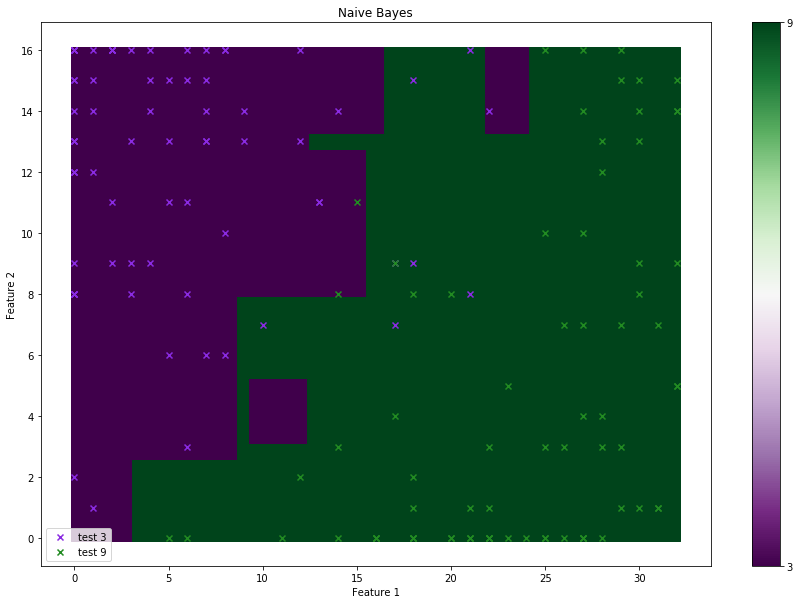

In [16]:
# Decision region
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_pred, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[3, 9])
# plot the test
ax.scatter(X_test_r[y_test == 3][:,0], X_test_r[y_test == 3][:,1], marker='x', color='blueviolet', label="test 3")
ax.scatter(X_test_r[y_test == 9][:,0], X_test_r[y_test == 9][:,1], marker='x', color='forestgreen', label="test 9")

# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Naive Bayes')
ax.legend(loc=3)
plt.show()

In [17]:
error_rates = []
for train, test in kf.split(X_all):
    # fitting
    histograms, binning = fit_naive_bayes(X_all_r[train], y_all[train], 8)
    # prediction
    prediction = predict_naive_bayes(X_all_r[test], histograms, binning)
    # calculation of error
    error_rates.append(np.count_nonzero(prediction - y_all[test])/prediction.shape[0])
mean_error = np.mean(error_rates)
std_error = np.std(error_rates)

print('Mean error rate on 10 folds: {:f} (std: {:f})'.format(mean_error, std_error))
print('This corresponds to {:f} wrong classifications'.format(mean_error*len(test)))

Mean error rate on 10 folds: 0.065916 (std: 0.070308)
This corresponds to 2.372973 wrong classifications
